
<h1><center>Red Neuronal - Keras</center></h1>


<center><i>Predicción de precios de vehiculos usados</i></center>




# <h1 id="problema">Contexto analítico y exploración de datos</h1>

El mercado de autos usados es reconocido por ser un sector economico muy competido con un centenar de compañias que luchan por hacerse con una porción de la torta. El precio de los autos se devalua año año debido a multiples factores y determinar el precio correcto es clave para las compañias para lograr competir en el mercado. En este caso se requiere implementar una red neural que permita determinar el valor más justo para los vehiculos dependiento de sus atributos:

* **year**: El año en que fue hecho el carro.
* **manufacturer**: La marca.
* **condition**: La condición del auto.
* **cylinders**: La cantidad de cilindros.
* **fuel**: Indica si es a gas o a gasolina.
* **transmision**: El tipo de trasmision.
* **size**: Tamaño.
* **type**: El tipo de vehiculo (convertible, pickup, etc).
* **paint_color**: Color.
* **price**: Precio o valor en dólares que vale. 

In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import io
from google.colab import files   #Librería necesaria para interactuar con archivos en Colab

In [2]:
#uploaded = files.upload()
#cars = pd.read_csv(io.StringIO(uploaded['Craiglist_Cars.csv'].decode('utf-8')), sep = ',' )
cars = pd.read_csv('Craiglist_Cars.csv', sep = ',' )
cars.head(3)

,year,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,price
0,2009,chevrolet,good,8 cylinders,gas,clean,automatic,rwd,full-size,SUV,white,9000
1,2002,gmc,good,8 cylinders,gas,clean,automatic,4wd,NaN,pickup,white,6000
2,2007,pontiac,excellent,4 cylinders,gas,clean,automatic,fwd,compact,convertible,red,7000


### 1. Conociendo dimensiones y conteo de clases en variables categoricas, completitud de las variables disponibles. 

A continuación identifiquemos el porcentaje de datos nulos que tiene el dataset.

In [3]:
print(cars.shape)
100*cars.isnull().sum()/cars.shape[0]

(434542, 12)


year             0.000000
manufacturer     3.646138
condition       36.860649
cylinders       28.306355
fuel             0.839505
title_status     0.662997
transmission     0.989087
drive           13.280189
size            58.133621
type            11.566661
paint_color     19.734571
price            0.000000
dtype: float64

In [4]:
types = pd.DataFrame(cars.dtypes)
print("Tipos de variables",types.groupby(0).size())
print(types)

Tipos de variables 0
int64      2
object    10
dtype: int64
                   0
year           int64
manufacturer  object
condition     object
cylinders     object
fuel          object
title_status  object
transmission  object
drive         object
size          object
type          object
paint_color   object
price          int64


In [5]:
categoricas = types.index[types[0] == 'O'].values     #muestra una lista con el nombre de las columnas tipo srt
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(cars[line].unique()))+" valores diferentes")

La variable manufacturer contiene: 43 valores diferentes
La variable condition contiene: 7 valores diferentes
La variable cylinders contiene: 9 valores diferentes
La variable fuel contiene: 6 valores diferentes
La variable title_status contiene: 7 valores diferentes
La variable transmission contiene: 4 valores diferentes
La variable drive contiene: 4 valores diferentes
La variable size contiene: 5 valores diferentes
La variable type contiene: 14 valores diferentes
La variable paint_color contiene: 13 valores diferentes


La idea hasta aquí es poder establecer que técnicas de imputación son posibles hasta aquí, considerando la cantidad de valores nulos.

In [6]:
for i in categoricas:
    print("Distribución de ",i,": \n", 100*cars[i].value_counts()/cars.shape[0],"\n")

Distribución de  manufacturer : 
 ford               17.966273
chevrolet          14.873591
toyota              7.667383
nissan              5.094789
honda               5.086045
jeep                4.915060
ram                 4.827381
gmc                 4.297628
dodge               3.775699
bmw                 2.687887
hyundai             2.462133
subaru              2.127988
mercedes-benz       2.062401
volkswagen          2.023280
chrysler            1.783947
kia                 1.712378
cadillac            1.504343
buick               1.329906
lexus               1.304592
mazda               1.288023
audi                1.187917
acura               0.865509
infiniti            0.783814
pontiac             0.766784
lincoln             0.685319
volvo               0.590507
mitsubishi          0.550004
mini                0.441154
rover               0.433330
mercury             0.412848
saturn              0.377639
jaguar              0.226906
fiat                0.153265
harley-da

<h1 id="ingenieria">Ingeniería de datos</h1>

Ahora se debe preparar la información para poder alimentar la red neuronal.

### 2. Tratamiento de información nula en las variables cuya tasa de nulos sea máximo el 10%

In [7]:
#Reemplazamos el tipo de actividad por la moda 
cars["fuel"] = cars["fuel"].fillna(cars["fuel"].mode()[0])                 #Usare el tipo de combustible,   fillna: para llenado de valores nulos

100*cars.isnull().sum()/cars.shape[0]                                      #100*cars.isnull().sum()/cars.shape[0]                                                 

year             0.000000
manufacturer     3.646138
condition       36.860649
cylinders       28.306355
fuel             0.000000
title_status     0.662997
transmission     0.989087
drive           13.280189
size            58.133621
type            11.566661
paint_color     19.734571
price            0.000000
dtype: float64

In [8]:
cars["title_status"] = cars["title_status"].fillna(cars["title_status"].mode()[0])
cars["transmission"] = cars["transmission"].fillna(cars["transmission"].mode()[0])
cars["manufacturer"] = cars["manufacturer"].fillna(cars["manufacturer"].mode()[0])

#Verificamos el cambio
100*cars.isnull().sum()/cars.shape[0]

year             0.000000
manufacturer     0.000000
condition       36.860649
cylinders       28.306355
fuel             0.000000
title_status     0.000000
transmission     0.000000
drive           13.280189
size            58.133621
type            11.566661
paint_color     19.734571
price            0.000000
dtype: float64

In [9]:
#cars=cars[['year','manufacturer', 'condition', 'cylinders','fuel', 'title_status', 'transmission', 'type', 'paint_color','price']]


Hasta este punto ya se ha mitigado el problemas de valores nulos (en variables numéricas) haciendo imputación por la moda.

### De categoricas a numéricas (de object a int64 )
Luego del procedimiento anterior se debe proceder a convertir las variables categoricas en variables numericas. Puede implementarse un método como el One Hot Encoding disponible en Scikit Learn. Sin embargo, usarremos una funcionalidad embedida en Pandas denominada ["get_dummies"](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html):

In [10]:
#categoricas = cars.columns
#categoricas

In [11]:
df= cars.copy()
for col in categoricas:
    df = pd.concat([df, (pd.get_dummies(df[col])).astype(int)], axis=1)
    df.drop(columns=[col],inplace=True)
    
    
#Al crear las variables dummies se crean varias columnas referentes a categorias
# 'other' que no aportan ningún valor al dataset por lo cual las eliminamos
df.drop('other', axis=1, inplace=True)   #la variable other no nos aporta información, se procede a eliminar tal variable
print(df.shape)
df.head(3)

(434542, 100)


,year,price,acura,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,datsun,dodge,ferrari,fiat,ford,gmc,harley-davidson,hennessey,honda,hyundai,infiniti,jaguar,jeep,kia,land rover,lexus,lincoln,mazda,mercedes-benz,mercury,mini,mitsubishi,morgan,nissan,pontiac,porche,ram,rover,saturn,...,hybrid,clean,lien,missing,parts only,rebuilt,salvage,automatic,manual,4wd,fwd,rwd,compact,full-size,mid-size,sub-compact,SUV,bus,convertible,coupe,hatchback,mini-van,offroad,pickup,sedan,truck,van,wagon,black,blue,brown,custom,green,grey,orange,purple,red,silver,white,yellow
0,2009,9000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2002,6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2007,7000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Se obtiene un dataset con 100 columas. Observemos ahora si todas las variables son tipo entero:

In [12]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int64    100
dtype: int64


In [13]:
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
#df.dtypes

In [14]:
df.dtypes

year            int32
price           int32
acura           int32
alfa-romeo      int32
aston-martin    int32
                ...  
purple          int32
red             int32
silver          int32
white           int32
yellow          int32
Length: 100, dtype: object

In [15]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
int32    100
dtype: int64


Especificando las features y la variable **respuesta**, para luego proceder a separar datos.

In [16]:
numeric_columns = list(set(types.index[types[0] =="int32"].values) - set(["price"]))   # int32   o   int64
variables_consolidadas = df[numeric_columns] 
objetivo = df["price"] #Variable objetivo de nuestra regresion.

variables_consolidadas.head(3)

,5 cylinders,white,green,audi,lexus,mitsubishi,brown,black,gmc,mercury,electric,full-size,salvage,salvage,land rover,ford,yellow,custom,hybrid,8 cylinders,3 cylinders,like new,new,bus,convertible,van,mini-van,blue,good,purple,4wd,12 cylinders,rover,ram,excellent,porche,rebuilt,lincoln,compact,truck,...,hatchback,sedan,subaru,nissan,6 cylinders,diesel,automatic,hyundai,coupe,aston-martin,lien,SUV,saturn,datsun,mazda,infiniti,missing,harley-davidson,gas,fair,chevrolet,jeep,morgan,red,pontiac,hennessey,clean,cadillac,4 cylinders,mini,silver,volkswagen,buick,bmw,toyota,10 cylinders,fwd,ferrari,parts only,alfa-romeo
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0


### 3. Separando el set de datos consolidados en 3 sets (entrenamiento, prueba y validación)

In [17]:
from sklearn.model_selection import train_test_split


#Entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.2,random_state=2020)   #se especifica una semilla para ser replicable
x_train.shape

(347633, 99)

In [18]:
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=2020)
x_train.shape

(312869, 99)

In [19]:
y_train=y_train.values.reshape(-1,1)    #cambiando la forma-tamaño del set
y_test=y_test.values.reshape(-1,1)
y_val=y_val.values.reshape(-1,1)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (312869, 99)
Shape of x_test: (86909, 99)
Shape of x_val: (34764, 99)
Shape of y_train: (312869, 1)
Shape of y_test: (86909, 1)
Shape of y_val: (34764, 1)


<h1 id="arquitectura">Diseño, Entrenamiento y Evaluación de la RN</h1>

Una vez consolidado los sets de información de entrenamiento, validacion y pruebas ya podemos iniciar a modelar nuestra red neuronal con las siguientes consideraciones:
* Primero hay que realiza la prueba con un par de arquitecturas iniciales.
* Como segundo paso hay que evaluar el desempeño de la red.
* Si el desempeño es bajo vuelve a la información y prueba estrategias de estandarización de la información.

### 4. Implementando una red neuronal con pérdidas (MSE) con el set de prueba sea menor a 0.40.

Se procede a estandarizar las features como la variable objetivo (price).

In [21]:
from sklearn.preprocessing import StandardScaler

#estandarizando features
scaler = StandardScaler()

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [22]:
#estandarizando variable objetivo
scaler1 = StandardScaler()

scaler1.fit(y_train)
y_train_scaled = scaler1.transform(y_train)
y_val_scaled = scaler1.transform(y_val)
y_test_scaled = scaler1.transform(y_test)

* Dado que se tiene 99 variables de entrada, se tiene que en la primera capa es óptimo tener 2*99=198 ----> $2^8=256$ en consecuencia se deben tener 256 neuronas en la primera capa.
* Segunda y tercera capa de a $2^7=128$ neuronas.

* la función de activación **relu**
* Para prevenir posibles efectos de sobreajuste se usará una **capa de regularización tipo dropput** para que apague el 20% de las neuronas.
* Por ser un problema de regresión la capa de salida tendrá una única neurona. (aquí la función de activación será **linear**)
* optimizer = "adam",
* función de perdidas **"mse"** y como métrica se usará el **"mean_absolute_error"**

El aprendizaje constará de estimar 75,137 parámetros.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model

model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation = "linear")) 
model.compile(optimizer = "adam",loss="mse",metrics=["mean_absolute_error"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 75,137
Trainable params: 75,137
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
#Entrenamiento
history =model.fit(x_train_scaled,y_train_scaled, validation_data = (x_val_scaled,y_val_scaled),epochs=50, batch_size=1024)

Epoch 1/50
306/306 [==============================] - 3s 4ms/step - loss: 0.6439 - mean_absolute_error: 0.5786 - val_loss: 0.4938 - val_mean_absolute_error: 0.4584
Epoch 2/50
306/306 [==============================] - 1s 3ms/step - loss: 0.4987 - mean_absolute_error: 0.4583 - val_loss: 0.4631 - val_mean_absolute_error: 0.4383
Epoch 3/50
306/306 [==============================] - 1s 2ms/step - loss: 0.4466 - mean_absolute_error: 0.4418 - val_loss: 0.4420 - val_mean_absolute_error: 0.4344
Epoch 4/50
306/306 [==============================] - 1s 2ms/step - loss: 0.4555 - mean_absolute_error: 0.4380 - val_loss: 0.4265 - val_mean_absolute_error: 0.4280
Epoch 5/50
306/306 [==============================] - 1s 3ms/step - loss: 0.4215 - mean_absolute_error: 0.4282 - val_loss: 0.4209 - val_mean_absolute_error: 0.4241
Epoch 6/50
306/306 [==============================] - 1s 3ms/step - loss: 0.4202 - mean_absolute_error: 0.4249 - val_loss: 0.4148 - val_mean_absolute_error: 0.4235
Epoch 7/50
306/3

Se puede observar que la arquitectura ha logrado una perdida de 0.3 con el set de entrenamiento 

#### Ahora realiza la evaluación del modelo con el set de entrenamiento.

In [25]:
result = model.evaluate(x_test_scaled,y_test_scaled)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",
str(round(result[i],2)))

2716/2716 [==============================] - 4s 1ms/step - loss: 0.3821 - mean_absolute_error: 0.3920
Metric  loss : 0.38
Metric  mean_absolute_error : 0.39


Si tu modelo cumple con el requerimiento, en este caso un error menor a 40% es pertinente guardarlo con el siguiente comando:

In [26]:
model.save('PrediccionPrecios.h5') #Guarda configuracion de red y parámetros, para volver a reutilizarlos sin necesidad de reentrenar.

### 5. Gráfico de la evolución en función de pérdidas a traves de las distintas épocas de entrenamiento.

A continuación se mostrará como la red neuronal ha aprendido epoca a epoca.

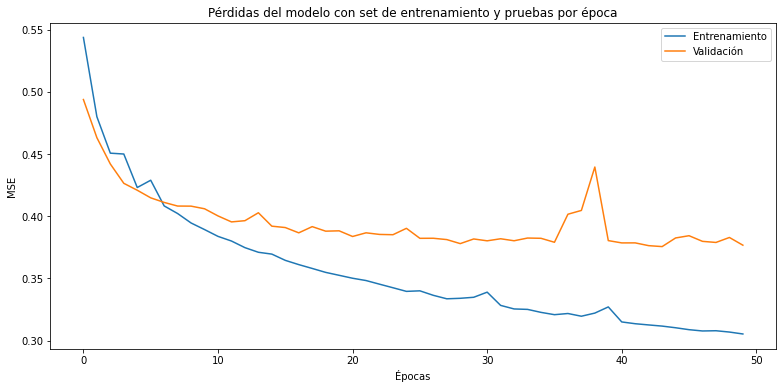

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

Al realizar las iteraciones la funcion de perdidas disminuia consecuentemente

---

#### predicciones con el modelo

Se recuerda que la información está estandarizada-escalada, pero para que tenga sentido en termino del precio de los automoviles (dolares) se debe realizar una transformacion inversa de esta normalización (con el método _inverse_transform(_) )

In [28]:
real=pd.DataFrame(y_train)
predic=model.predict(pd.DataFrame(x_train_scaled))         #haciendo predicciones pero con valores estandarizados
valores_reescalados = scaler1.inverse_transform(predic)   #haciendo la transformación inversa la cual tiene las prediucciones en dólares
pred_escal =pd.DataFrame(valores_reescalados)             #se convierte en dataFrame para poder recorrerlo


# Muestra los valores reales y las predicciones
for i in range(0,5):
	print("Real=%s, Prediccion=%s" % (real[0][i], pred_escal[0][i]))

Real=18650, Prediccion=15935.212
Real=9950, Prediccion=8274.526
Real=2000, Prediccion=1502.7583
Real=7999, Prediccion=6533.5864
Real=23999, Prediccion=25750.332


Anteriormete se muestra el valor real y el predicho.